# Generate Synthetic Time Histories for Wind Power Generation

## Background: 
The University of Illinois has a power purchase agreement with Rail Splitter Wind Farm in Lincoln, IL. 

* The wind farm has a capacity of 100.5 MW from 67 GE 1.5 MW wind turbines.
* UIUC buys 8.6% of power generated at 4 cents/kWh or $\$4$/MWh
* The agreement is for 10 years (2016-2026). 
* Info about the specific wind turbines is available here: https://en.wind-turbine-models.com/turbines/655-general-electric-ge-1.5sle


## About the data

The data used in this analysis was obtained from a subdivision of the National Oceanic and Atmospheric Administration (NOAA), National Centers for Environmental Information (NECI). The data was collected by a land-based weather station located at the Lincoln Illinois Airport for the years of 2010-2019. 

https://www.ncdc.noaa.gov/data-access

The data is stored on Box rather than locally. 

## Set up the Box API to access data

These cells with Box API commands have been converted to raw text so they won't accidentally be run. To convert back to runnable cells: 

``enter`` (enters command mode)

``y`` (converts selected cell to code)

In [1]:
%%capture 
!pip install boxsdk
# %%capture captures the output from pip install... comment out if there are installation issues.

In [1]:
from boxsdk import Client, OAuth2

# Defines client ID, secrete, and developer token
CLIENT_ID = 'ey8yzp3yxanb3jjujb2s95c1bnouz2o8'
CLIENT_SECRET = 'VGGJjHGWfBm0MHq1xIqncxZDolelVIDP'
ACCESS_TOKEN = 'oVXf0J97N0WHYSOIaEpPBpuaGqrddYxA' # only valid for 60 minutes...?

# Creates the client instance
oauth2 = OAuth2(CLIENT_ID, CLIENT_SECRET, access_token=ACCESS_TOKEN)

client = Client(oauth2)

In [2]:
# Folder IDs 
gridload_id = 92229909420
solarfarm_id = 92974470362
solarmodel_id = 92182116657
steam_id = 92620146668
weather_id = 90175362988

#### A better way to obtain the data... 
Since there is a specific file in Box that I am manipulating here, why not try using ``$curl`` with a shared link?

First attempt: nothing downloaded.

Solution: add ``-L`` flag to force the download by following redirects.

This downloads the links... not the data. Not sure how to resolve at this point. It takes about 30 seconds to obtain a new developer key from box. But I want to be able to run this notebook without that (open source, right?) and I'm not sure how at this point (12/18/2019). 

In [3]:
# convert to runnable cell by going to command mode --> y
# Gets the file with the data
lincoln_file = client.file(file_id=578216725033)

# Import to a pandas dataframe
import pandas as pd

path = './lincoln_weather.csv'
with open(path, 'wb') as file:
    lincoln_file.download_to(file)

lincoln_wind = pd.read_csv(path, usecols=['HourlyWindSpeed', 'HourlyDryBulbTemperature', 
                                          'HourlyStationPressure','HourlyRelativeHumidity',
                                          'DATE'])

# Removes the file from the local directory
# !rm -rf lincoln_weather.csv

# when I'm using a windows computer 
!del lincoln_weather.csv

C:\Users\samgd\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (43,51,56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from data_funcs import to_float

In [5]:
# convert to datetime
lincoln_wind.DATE = pd.to_datetime(lincoln_wind.DATE)

# rename columns
lincoln_wind.rename(columns={'DATE':'time',
                             'HourlyDryBulbTemperature': 'temp',
                             'HourlyRelativeHumidity':'RH', 
                             'HourlyStationPressure':'pressure',
                             'HourlyWindSpeed': 'u'}, inplace=True)

In [6]:
# Verify that the dataframe has float values
lincoln_wind = to_float(lincoln_wind, 'temp')
lincoln_wind = to_float(lincoln_wind, 'u')
lincoln_wind = to_float(lincoln_wind, 'RH')
lincoln_wind = to_float(lincoln_wind, 'pressure')

lincoln_wind.index = pd.to_datetime(lincoln_wind.time)


In [7]:
# check if there are NaN values
print("The data frame is missing values:", lincoln_wind.isnull().values.any())

# interpolate
lincoln_wind = lincoln_wind.interpolate(method='linear')

# check if there are NaN values
print("The data frame is missing values:", lincoln_wind.isnull().values.any())

The data frame is missing values: True
The data frame is missing values: False


In [8]:
# resample by hour to get single measurements for each hour
lincoln_wind = lincoln_wind.resample('H').mean()

## Calculate the Power to Campus

This analysis will use the following model from 
>H. E. Garcia et al., “Nuclear Hybrid Energy Systems Regional Studies: West Texas & Northeastern Arizona,” Idaho National Lab. (INL), Idaho Falls, ID (United States), INL/EXT-15-34503, Apr. 2015.

#### Operating Regimes
* Above the cut-out and below the cut-in speeds, the turbines produce no power. 
* Between the rated speed and the cut-out speeds the turbines produce a constant rated power.
* Between the cut-in speed and the rated speeds the turbines produce power given by 

$P = 0.5\eta\rho U_h^3\frac{\pi d^2}{4} [\text{W}_e]$

_(in Baker et. al they claim this formula gives the value in MW, this appears to be untrue)_

where 
* $\eta$ is the conversion efficiency (not given for these turbines, so we assume 35%)
* $\rho$ is the density of air at the location (based on temperature)
* $d$ is the diameter of the turbine (2 x blade length). 


The density of air, $\rho$, can be calculated with the following: 

$\rho = \frac{P_{dry}}{R_{dry}T} + \frac{P_{vapor}}{R_{vapor}T}$

The vapor pressure $P_{vapor}$ can be calculated using the Clausius-Clapeyron Equation which gives the saturation vapor pressure over water.

$P_{vapor} = e_s * RH$

$e_s = 0.6112e^{\frac{17.67T}{T+243.5}} [\text{kPa}]$
>Iribarne, J. V., and W. L. Godson 1981. Atmospheric Thermodynamics. D. Reidel, . p. 65.

* $T$ : Temperature in $^\circ C$
* $R_{dry}$ : 287.058 J/(kg·K)
* $R_{vapor}$ : 461.495 J/(kg·K)
* $RH$ : Relative Humidity


### Solving the Units Problem

The model given by Baker et. al is supposedly in MWe. However the results from this do not produce values similar to the values stated by Rail Splitter. 


Rail Splitter's Claim:
>In November 2016, the campus received nearly 2400 MWh based on actual wind farm speeds.

Let's nail this down by isolating the wind speed data from November 2016


The model proposed by Garcia et. al corresponds the kinetic energy of wind to power produced. Start with 

1. $P = \frac{1}{2}\dot{m}U^2$ with units of $[W] = \frac{[J]}{[s]} = \frac{[N][m]}{[s]} = \frac{[kg][m]^2}{[s^3]}$

The mass flux through the wind turbines is given by: 

2. $\dot{m} = \rho A_f U$ with units of $\frac{[kg]}{[m^3]}[m^2]\frac{[m]}{[s]} = \frac{[kg]}{[s]}$

Plug (2) into (1) 

3. $P = \frac{1}{2} (\rho A_f U)U^2$

In order to obtain the model from Garcia et. al we must multiply by a conversion factor, $\eta$ because we cannot use 100% of the energy stored in wind. We can also replace the flow area, $A_f$, by $\frac{\pi d^2}{4}$ because that is the cross section area of the turbine. 
Finally, 

4. $P = \frac{1}{2}\eta\rho \frac{\pi d^2}{4}U^3$

### Solving the mismatch between Rail Splitter's claim and the data from Lincoln Airport

At the moment (12/22/19) the largest value for MW from the real data I curated was ~660 MWe. This is in stark contrast to Rail Splitter Wind Farm's stated 2400 MWe in November 2016. It is highly unlikely that there is a criminal conspiracy here so there must be something wrong with either: 
1. How I'm calculating power
2. The wind speeds I am using
Initially, I thought that the error must lie with how I was calculating power. After going through the quick derivation above, I am confident my calculations are correct. Thus there must be something wrong with the data. After some thought, there is actually nothing _wrong_ with the data, but it is likely that the wind speed measurements were taken somewhere around 10m above the ground, while the hub height of the wind turbines is around 60m. Wind speeds can be significantly greater at higher altitudes. 
After much digging, I found a way to extrapolate the wind speed to higher altitudes using a ''log law'' from 

J. F. Manwell, J. G. McGowan, and A. L. Rogers, Wind Energy Explained: Theory, Design and Application, 2nd ed. Wiley, 2010.

and criteria for roughness lengths from the European Wind Atlas, 

I. Troen and E. L. Petersen, European Wind Atlas. Commission of the European Communities Directorate-General for Science, 1989.

The formula is

$v \approx v_{ref}\frac{\ln\left(\frac{z}{z_0}\right)}{\ln\left(\frac{z_{ref}}{z_0}\right)}$

where
* $z_{ref}$ is the reference height, in our case we are _assuming_ 10m.
* $v_{ref}$ is the wind speed at the reference height.
* $z_0$ is the roughness length for a certain terrain type as outlined in the Europen Wind Atlas (EWA).
* $z$ is the height of interest. In this case we are interested in 50-60m. 

Because the wind speed measurements were taken at an airport, we will start by using $z_0 = 0.0024$ from EWA. 

In [9]:
# convert windspeed to m/s from mph

to_ms = lambda u: u/2.237
lincoln_wind['u'] = lincoln_wind['u'].apply(to_ms)

In [10]:
# extrapolate windspeeds to a height of 50m
z0 = 0.0024 # [m]
z = 50 # [m]
zref = 10 # [m]
speed_extrap = lambda v: v*(np.log(z/z0)/np.log(zref/z0))
lincoln_wind['u_ex'] = lincoln_wind['u'].apply(speed_extrap)

lincoln_wind

,temp,RH,pressure,u,u_ex
time,,,,,
2010-12-11 00:00:00,34.333333,90.666667,29.306667,2.682164,3.200081
2010-12-11 01:00:00,32.000000,95.333333,29.293333,2.533155,3.022299
2010-12-11 02:00:00,33.000000,95.333333,29.283333,3.725227,4.444557
2010-12-11 03:00:00,34.000000,91.666667,29.270000,3.427209,4.088993
2010-12-11 04:00:00,34.000000,93.000000,29.250000,2.980182,3.555646
2010-12-11 05:00:00,34.333333,92.000000,29.216667,3.725227,4.444557
2010-12-11 06:00:00,36.000000,90.000000,29.190000,4.023245,4.800122
2010-12-11 07:00:00,36.000000,92.333333,29.166667,3.874236,4.622339
2010-12-11 08:00:00,36.000000,93.666667,29.146667,4.023245,4.800122


In [48]:
# lincoln_wind[lincoln_wind['u'] >= 11.5]

In [11]:
# convert the temperature to Celsius
to_celsius = lambda T : (T-32)*5/9

lincoln_wind['temp'] = lincoln_wind['temp'].apply(to_celsius)

# lincoln_wind

In [12]:
# convert pressure to Pascals
to_pa = lambda P: P*3386.38867

lincoln_wind['pressure'] = lincoln_wind['pressure'].apply(to_pa)

# lincoln_wind

In [13]:
# calculate air density in g/m^3 --> wrong units.
# 12/20/19: Divide by 1000 to get kg/m^3
# 12/20/19: Edit 2, the density was already in kg/m^3. 

# define constants
Rv = 461.495
Rd = 287.058

# define functions
es = lambda T: 611.2*np.exp(17.67*T/(T+243.5)) # saturation vapor pressure over water
rho = lambda T, P, Rh, Pv: (es(T)*(Rh/100))/(Rv*(T+273.15))+(P-(es(T)*(Rh/100)))/(Rd*(T+273.15)) # density of air 


density = {'rho':[]}
for i in range(len(lincoln_wind)):
    T = lincoln_wind.iloc[i]['temp']
    P = lincoln_wind.iloc[i]['pressure']
    Rh = lincoln_wind.iloc[i]['RH']
    Pv = es(T)
    density['rho'].append(rho(T, P, Rh, Pv))
lincoln_wind['rho'] = density['rho']

# lincoln_wind

In [17]:
# calculate the power generated

# define constants
N = 67 # the number of wind turbines
d = 77 # [m]
r = d/2 # [m]
u_in = 3.5 # [m/s]
u_out = 25.0 # [m/s]
u_ideal = 12 # [m/s]
eta = 0.31 # efficiency
ppa = 8.6/100 # the percentage of purchased power.
pmax = 1.5 # [MW], the rated power for a single turbine

P = lambda U, rho: N*ppa*(0.5*eta*rho*(U**3)*(np.pi*r**2))/1e6 # this is in Watts, dividing by 1e6 gives MW

# calculate all values of power
power = []
for i in range(len(lincoln_wind)):
    U = lincoln_wind.iloc[i]['u_ex']
    rho = lincoln_wind.iloc[i]['rho']
    power.append(P(U, rho))
lincoln_wind['power'] = power

# fix based on cut in and cut out speeds
zero = (lincoln_wind.u_ex <= u_in) | (lincoln_wind.u_ex >= u_out)
peak = (lincoln_wind.u_ex > u_ideal) & (lincoln_wind.u_ex < u_out)

lincoln_wind['power'].mask(zero, 0, inplace=True)
lincoln_wind['power'].mask(peak, N*ppa*pmax, inplace=True)

In [18]:
years = lincoln_wind.groupby(lincoln_wind.index.year)
data2016 = years.get_group(2016)
months = data2016.groupby(data2016.index.month)
november16 = months.get_group(11)

# november16

In [19]:
november16['power'].sum()

365.55787843584534

### The above is very concerning. 

I am not sure where the calculation could be wrong because the model is just simple physics. It is possible that the wind speed units are incorrect although I think this is unlikely. The air densities are correct as well. 

Rail Splitter claimed to send the campus 2400 MWe in November 2016 but this shows way lower values. 

### Step 2: Group by year

In [74]:
# lincoln_w['time'] = lincoln_wind.index


# leap years drop the last day. Each year needs to be the same length.
grouped = lincoln_interp.groupby(lincoln_interp.index.year)
df11 = grouped.get_group(2011)
df12 = grouped.get_group(2012)[:8760]
df13 = grouped.get_group(2013)
df14 = grouped.get_group(2014)
df15 = grouped.get_group(2015)
df16 = grouped.get_group(2016)[:8760]
df17 = grouped.get_group(2017)
df18 = grouped.get_group(2018)

# create a column of hours
df11 = df11.reset_index(drop=True)
df12 = df12.reset_index(drop=True)
df13 = df13.reset_index(drop=True)
df14 = df14.reset_index(drop=True)
df15 = df15.reset_index(drop=True)
df16 = df16.reset_index(drop=True)
df17 = df17.reset_index(drop=True)
df18 = df18.reset_index(drop=True)

df11['time'] = df11.index
df12['time'] = df12.index
df13['time'] = df13.index
df14['time'] = df14.index
df15['time'] = df15.index
df16['time'] = df16.index
df17['time'] = df17.index
df18['time'] = df18.index

df11 = df11[['time','power']]
df12 = df12[['time','power']]
df13 = df13[['time','power']]
df14 = df14[['time','power']]
df15 = df15[['time','power']]
df16 = df16[['time','power']]
df17 = df17[['time','power']]
df18 = df18[['time','power']]

In [87]:
# =============================================
# writes the header file for RAVEN
fname = 'annual_wind201'
wind_keys = [fname + str(i) + '.csv' for i in range(1,9,1)]
header_file = pd.DataFrame({'n':np.zeros(len(wind_keys), dtype=np.int8), 'filename':wind_keys})
header_file.to_csv('annual_wind_H.csv')
# header_file

In [76]:
# save the data frames as files that can be passed to RAVEN.
df11.to_csv('annual_wind2011.csv')
df12.to_csv('annual_wind2012.csv')
df13.to_csv('annual_wind2013.csv')
df14.to_csv('annual_wind2014.csv')
df15.to_csv('annual_wind2015.csv')
df16.to_csv('annual_wind2016.csv')
df17.to_csv('annual_wind2017.csv')
df18.to_csv('annual_wind2018.csv')

## Pass the data to RAVEN

RAVEN will return a typical year of wind power production.

In [88]:
!ls

annual_wind2011.csv  annual_wind2015.csv  annual_wind_H.csv  TypicalWind_0.csv
annual_wind2012.csv  annual_wind2016.csv  data_funcs.py      TypicalWind.csv
annual_wind2013.csv  annual_wind2017.csv  __pycache__	     TypicalWind.xml
annual_wind2014.csv  annual_wind2018.csv  tests		     wind_power.ipynb


In [89]:
#upload the typical annual wind generation
typical_wind = pd.read_csv('TypicalWind_0.csv')
typical_wind

,time,power
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
...,...,...
8755,8755,0.0
8756,8756,0.0
8757,8757,0.0
8758,8758,0.0


In [95]:
typical_wind['date'] = pd.date_range(start='1/1/2018', end='1/1/2019', freq='H')[:8760]
typical_wind

,time,power,date
0,0,0.0,2018-01-01 00:00:00
1,1,0.0,2018-01-01 01:00:00
2,2,0.0,2018-01-01 02:00:00
3,3,0.0,2018-01-01 03:00:00
4,4,0.0,2018-01-01 04:00:00
...,...,...,...
8755,8755,0.0,2018-12-31 19:00:00
8756,8756,0.0,2018-12-31 20:00:00
8757,8757,0.0,2018-12-31 21:00:00
8758,8758,0.0,2018-12-31 22:00:00


In [103]:
# let's calculate the annual power generated

power_gen = typical_wind['power'].sum()
power_gen

2111.95481808893

#### 2111 MWe seems low... how does it compare to other years?

In [108]:
df12_power = df12['power'].sum()
print(df12_power)
df11_power = df11['power'].sum()
print(df11_power)
df13_power = df13['power'].sum()
print(df13_power)
df14_power = df14['power'].sum()
print(df14_power)
df15_power = df15['power'].sum()
print(df15_power)
df16_power = df16['power'].sum()
print(df16_power)
df17_power = df17['power'].sum()
print(df17_power)
df18_power = df18['power'].sum()
print(df18_power)

2969.215572809362
3196.1166240096477
2222.5519048420806
2612.1456759766706
2582.499599989362
1869.9016153686896
2375.0667534981844
2086.7604099181403


#### We will get to the bottom of this, let's look at the values predicted by Rail Splitter in the PPA

In [147]:
# from Rail Splitter Wind Farm

max_power = 100.5 #[MW]

#if 100% production
max_produced = max_power*8760
print(max_produced)
#UIUC gets 8.6% of produced power
uiuc_received = max_produced*0.086

print(uiuc_received)

880380.0
75712.68


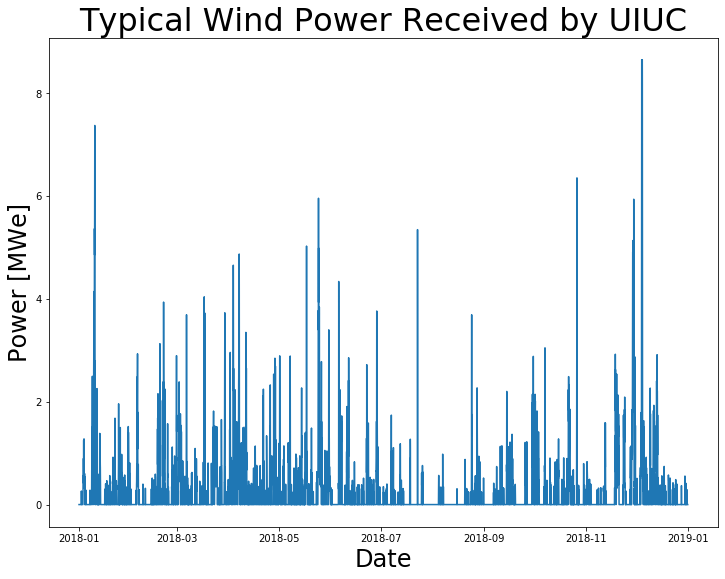

In [105]:
fig = plt.figure(figsize=(12,9), facecolor='w', edgecolor='k')
plt.plot(typical_wind['date'], typical_wind['power'])
plt.xlabel('Date',fontsize=24)
plt.ylabel('Power [MWe]',fontsize=24)
plt.title('Typical Wind Power Received by UIUC',fontsize=32)
plt.show()

When the analysis is finished we can safely delete the built files from the local directory

In [101]:
# delete built files
!rm -rf *.xml *.csv

In [102]:
!ls

data_funcs.py  __pycache__  tests  wind_power.ipynb
